Reading data...
... reading from cache file cache/DATA05-home-jiwoolim24-test-scRNAseq_Workshop-matrix.h5ad
filtered out 19024 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/DATA05/home/jiwoolim24/.local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


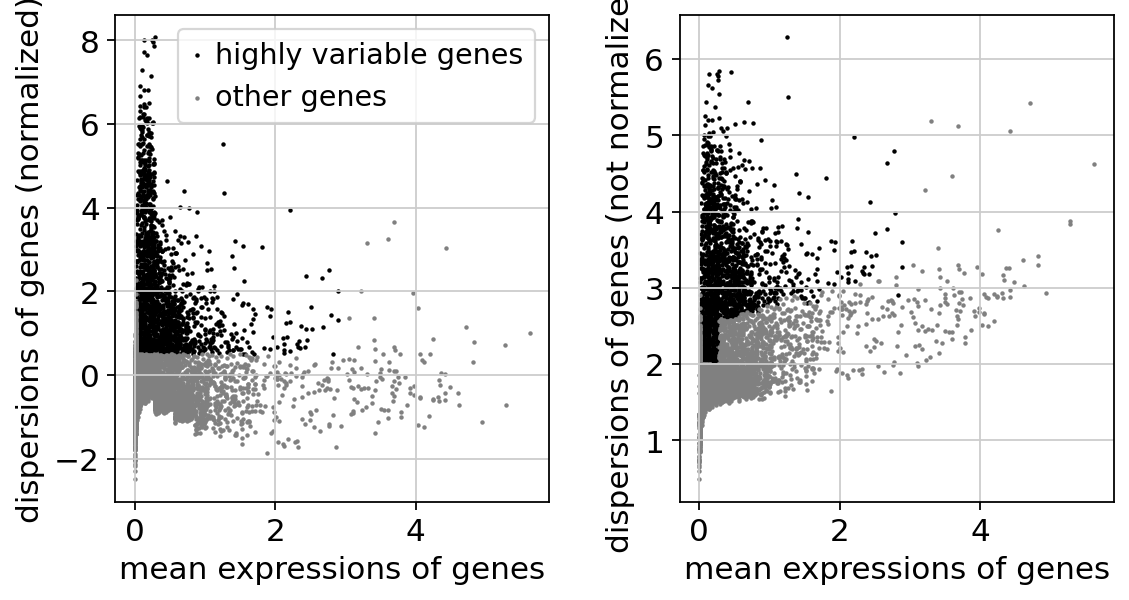

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    with n_comps=50
    finished (0:00:00)


/DATA05/home/jiwoolim24/.local/lib/python3.9/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


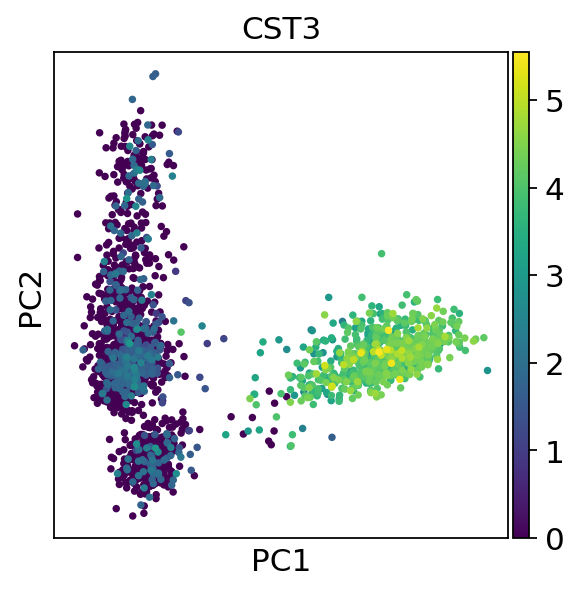

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


In [31]:
#scanpy tutorial day 3
#load required libraries
# NumPy → numbers & arrays
#Pandas → tables
#Matplotlib → basic plots
#Seaborn → prettier plots/statistics
#Scanpy → single-cell RNA-seq (uses all of the above under the hood)

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor='white')

#set up directory
large_root = "/DATA05/home/jiwoolim24/test/scRNAseq_Workshop"
results_file = large_root + "\pbmc3k.h5ad"

#load data
print("Reading data...")
adata = sc.read_10x_mtx(large_root, var_names = 'gene_symbols',
                        cache=True)

# annotate mitochondrial genes as 'mt' and calculate qc metrics
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

#basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# actually do the filtering by slicing the AnnData object
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

# normalize counts to 10,000 reads per cell..
sc.pp.normalize_total(adata, target_sum=1e4)

#log n+1 transform
sc.pp.log1p(adata)

# identify highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

#plot dispersion vs expression
sc.pl.highly_variable_genes(adata)

#filter to only include HVGs
adata.raw = adata
adata = adata[:, adata.var.highly_variable]

#scale to unit variance for PCA, clip values exceding var 10
sc.pp.scale(adata, max_value=10)

# reduce the dimensionality of the data with PCA
sc.tl.pca(adata, svd_solver='arpack')

#scatter in the PCA coordinates, won't be used later on, only for vis
sc.pl.pca(adata, color='CST3')

#save the result
adata.write(results_file)

#computing the neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)

#calculating umap coordinates
sc.tl.umap(adata)

############ day 3 new material


In [43]:

#clustering the neighborhood graph
# run leiden clustering
sc.tl.leiden(adata, resolution = 0.9) # resoultion: A parameter value controlling the coarseness of the clustering. Higher values lead to more clusters. Set to `None` if overriding `partition_type` to one that doesn’t accept a `resolution_parameter`.


running Leiden clustering
    finished (0:00:00)


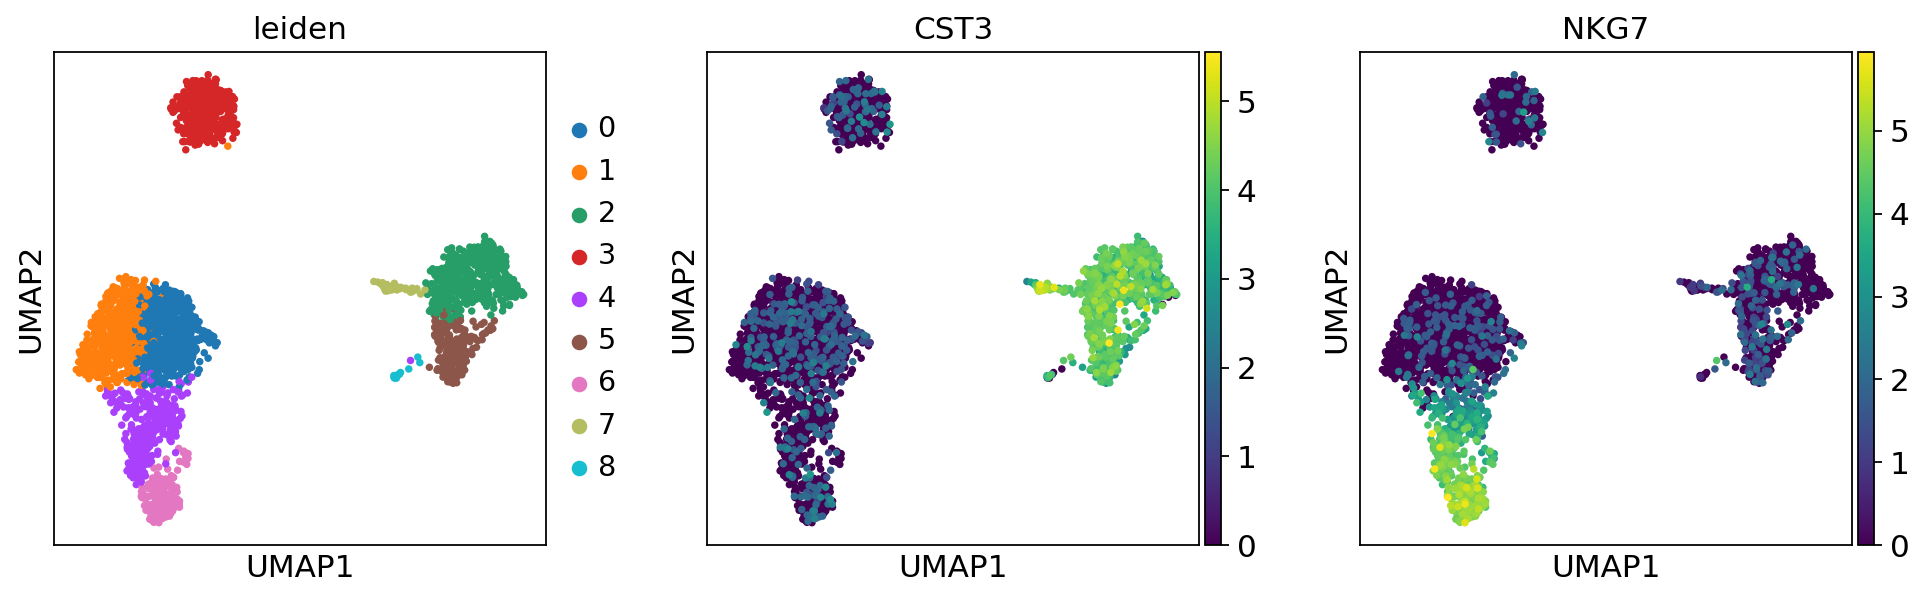

In [44]:
#plot the clusters
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

#save results
adata.write(results_file)


running PAGA
    finished (0:00:00)


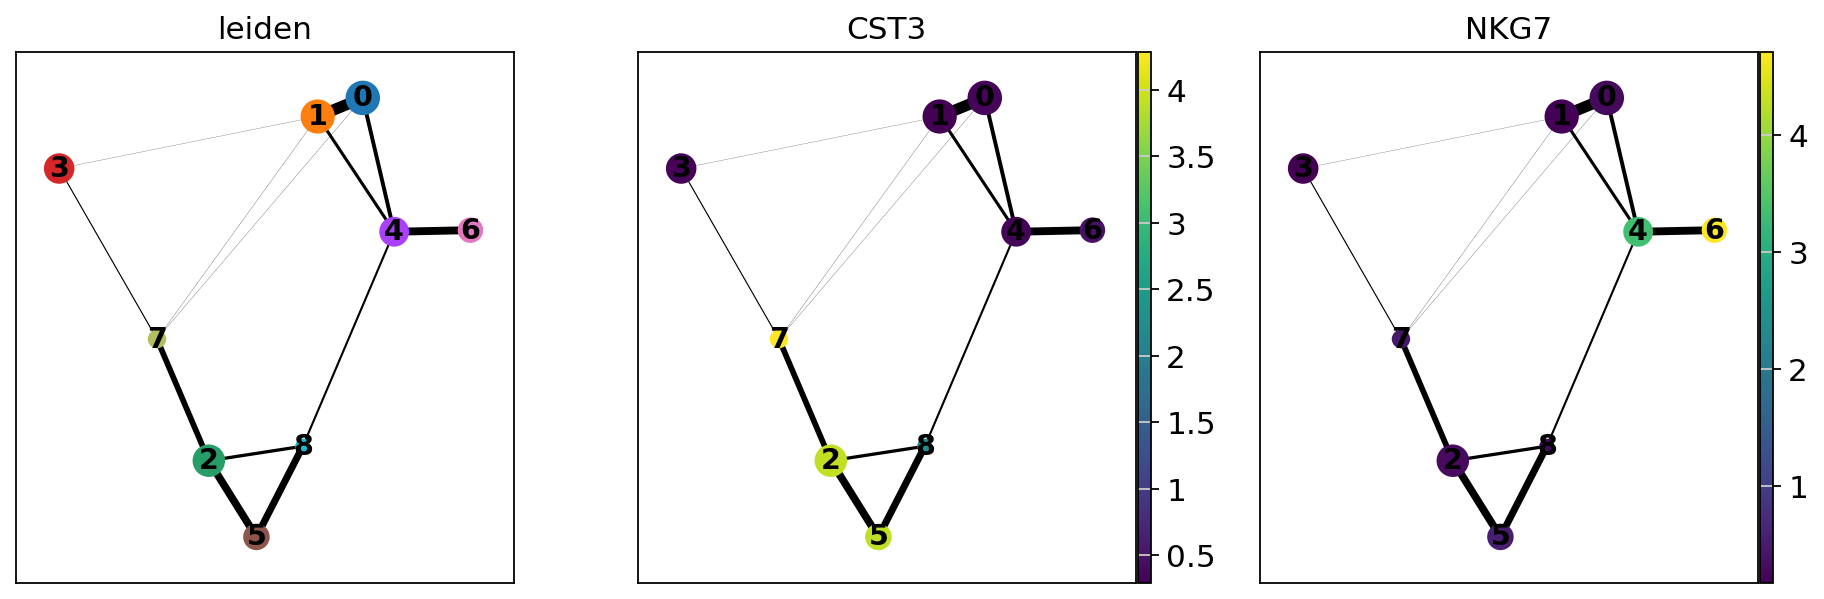

In [45]:
#compute PAGA graph to cluster labels or our marker genes of interests
sc.tl.paga(adata, groups='leiden')
sc.pl.paga(adata, color=['leiden', 'CST3', 'NKG7'])

drawing single-cell graph using layout 'fa'
    finished (0:00:05)


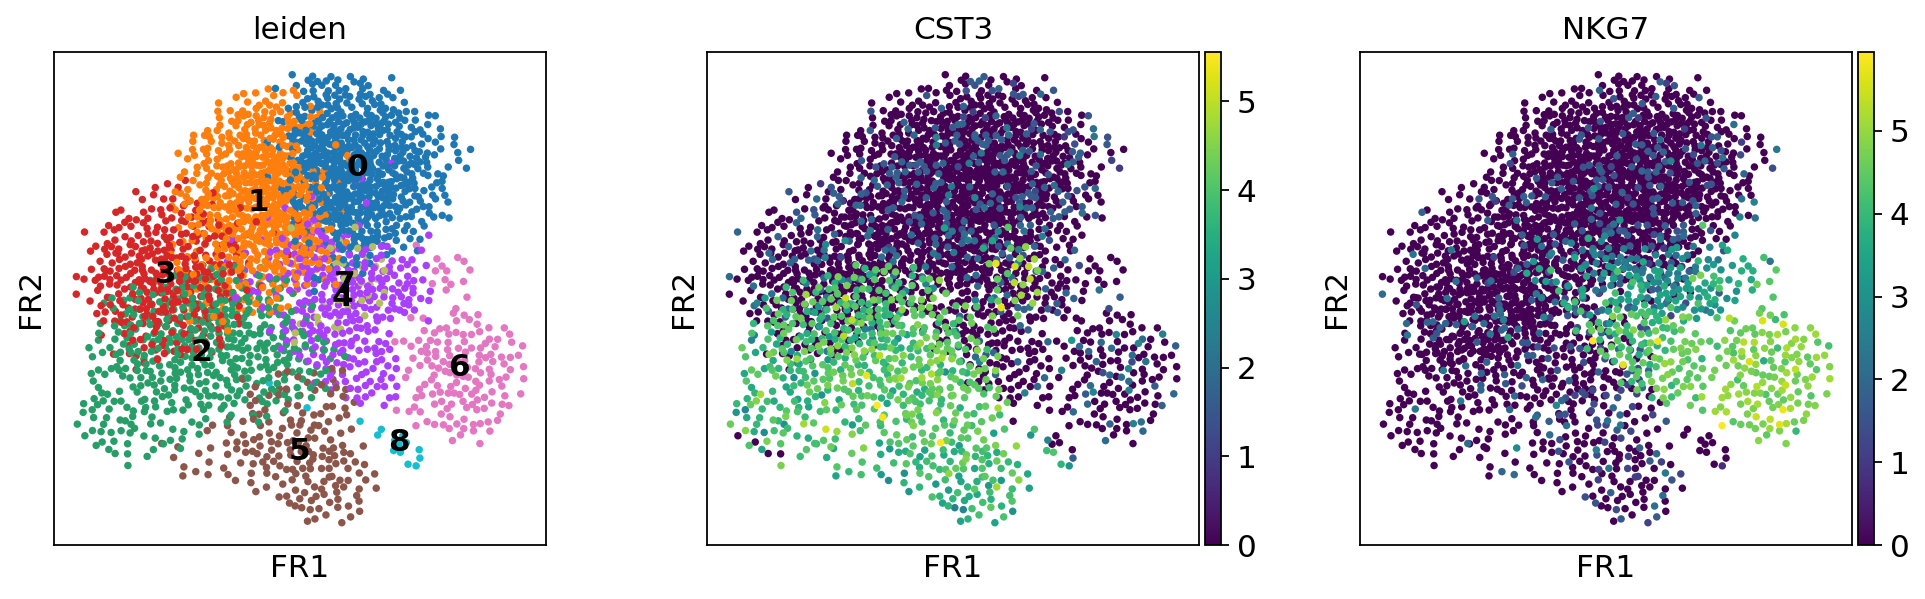

In [46]:
#recompute embedding using PAGA initialization
sc.tl.draw_graph(adata, init_pos='paga')
sc.pl.draw_graph(adata, color=['leiden', 'CST3', 'NKG7'], legend_loc='on data')

In [17]:
#########

ranking genes
    finished (0:00:02)


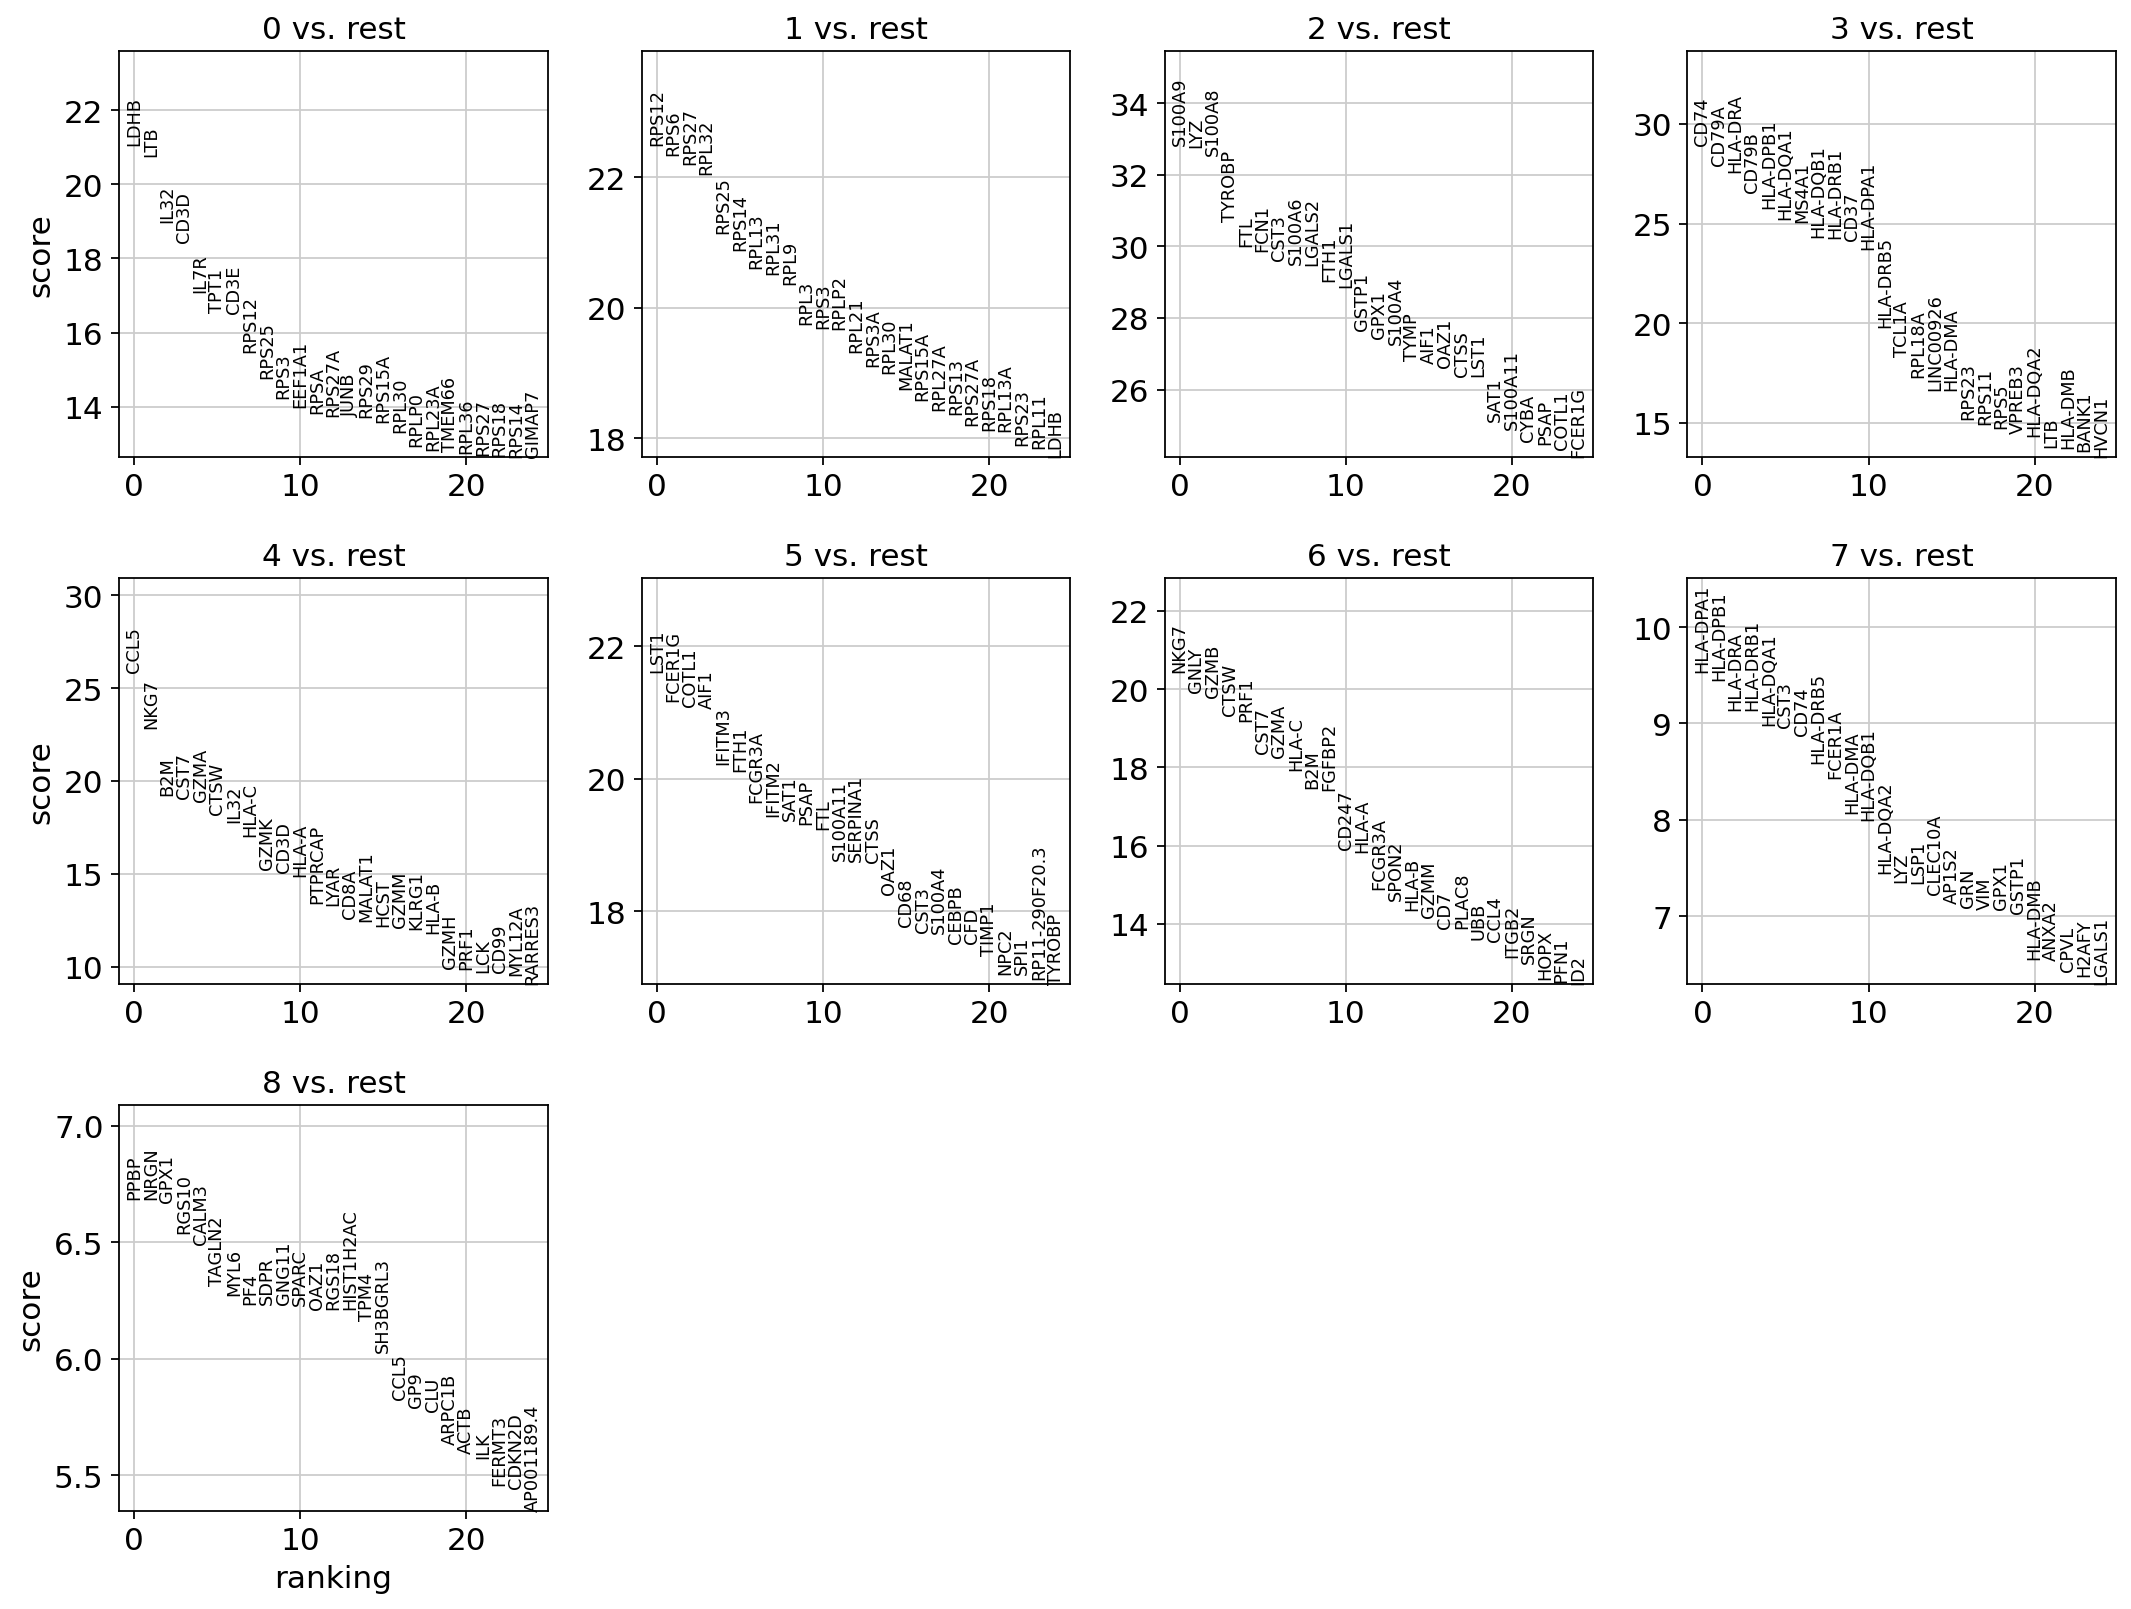

In [47]:
#compute ranking for differential genes in each cluster in adata groups
#find marker genes
#use raw data
#using wilcoxon rank-sum
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
adata.write(results_file)

In [48]:
sc.settings.verbosity = 2 #reduce the verbosity

#define list for reference
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

adata = sc.read(results_file)

#show the results
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)


,0,1,2,3,4,5,6,7,8
0,LDHB,RPS12,S100A9,CD74,CCL5,LST1,NKG7,HLA-DPA1,PPBP
1,LTB,RPS6,LYZ,CD79A,NKG7,FCER1G,GNLY,HLA-DPB1,NRGN
2,IL32,RPS27,S100A8,HLA-DRA,B2M,COTL1,GZMB,HLA-DRA,GPX1
3,CD3D,RPL32,TYROBP,CD79B,CST7,AIF1,CTSW,HLA-DRB1,RGS10
4,IL7R,RPS25,FTL,HLA-DPB1,GZMA,IFITM3,PRF1,HLA-DQA1,CALM3


In [49]:
#get a table with scores and groups
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p,8_n,8_p
0,LDHB,1.782771e-98,RPS12,4.488642e-112,S100A9,1.954996e-236,CD74,3.050940e-184,CCL5,1.128317e-147,LST1,1.312550e-103,NKG7,6.743114e-93,HLA-DPA1,1.482522e-21,PPBP,2.275469e-11
1,LTB,1.246184e-95,RPS6,1.240729e-110,LYZ,9.545161e-236,CD79A,1.103133e-171,NKG7,2.415252e-115,FCER1G,1.891808e-99,GNLY,2.097157e-88,HLA-DPB1,3.493551e-21,NRGN,2.307390e-11
2,IL32,2.611197e-80,RPS27,2.746950e-109,S100A8,3.145417e-232,HLA-DRA,1.312323e-167,B2M,1.092332e-82,COTL1,8.200568e-99,GZMB,3.026449e-87,HLA-DRA,6.202612e-20,GPX1,2.496729e-11
3,CD3D,6.551515e-76,RPL32,8.549301e-108,TYROBP,5.541171e-207,CD79B,1.710306e-155,CST7,3.252355e-81,AIF1,1.362239e-98,CTSW,2.573822e-83,HLA-DRB1,6.431102e-20,RGS10,6.077253e-11
4,IL7R,1.506794e-65,RPS25,2.720272e-99,FTL,8.623988e-198,HLA-DPB1,8.268102e-147,GZMA,8.428198e-80,IFITM3,5.892607e-91,PRF1,5.140055e-82,HLA-DQA1,2.660057e-19,CALM3,8.497955e-11


ranking genes
    finished (0:00:00)


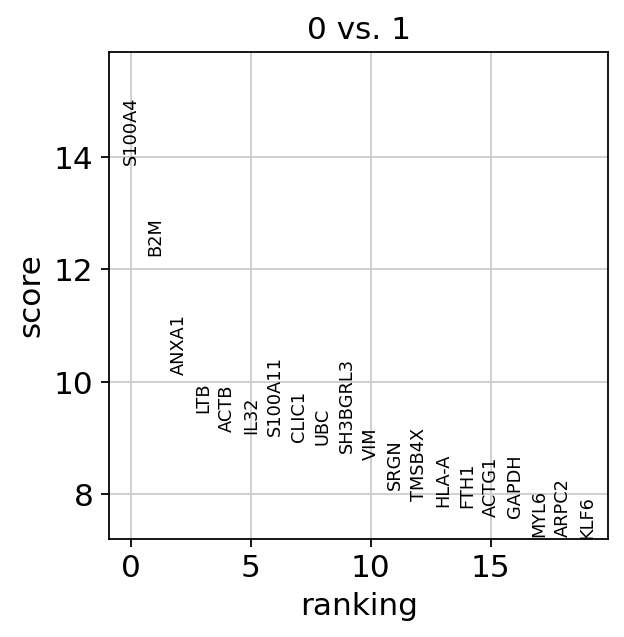

/DATA05/home/jiwoolim24/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/__init__.py:1320: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


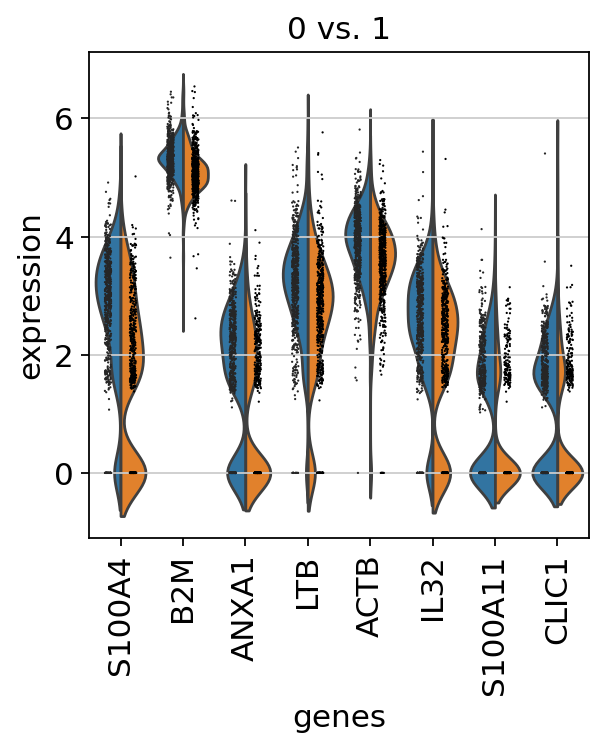

/DATA05/home/jiwoolim24/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/__init__.py:1320: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


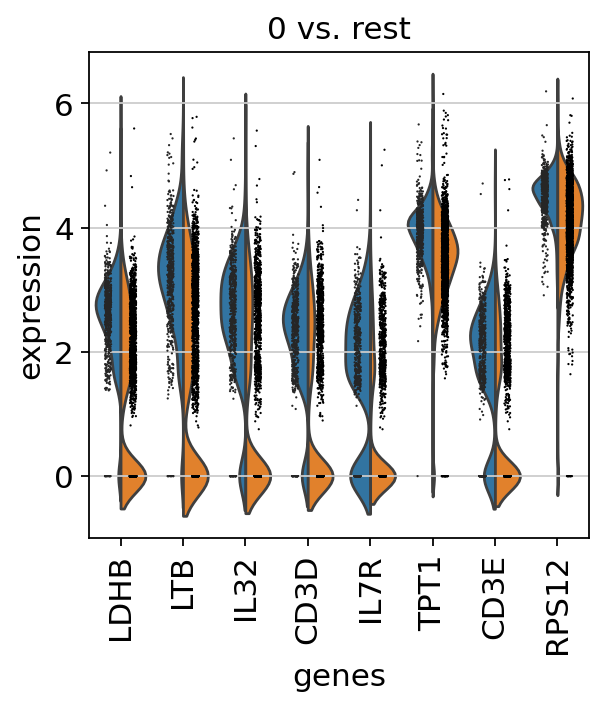

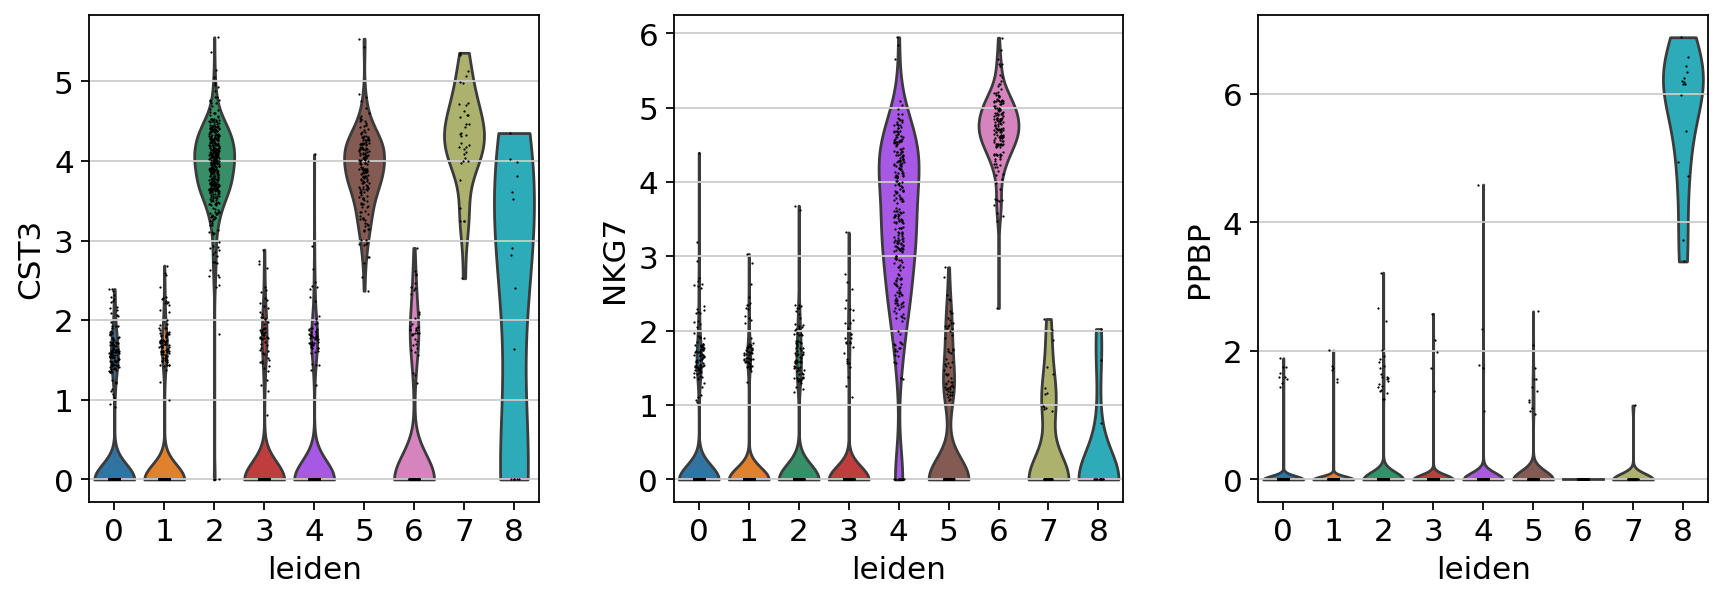

In [50]:
#compare to a single cluster

sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

#plot distributions with violin plot
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

#compare cluster 0 to rest of groups
adata = sc.read(results_file)
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

#compare a certain gene across groups
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')

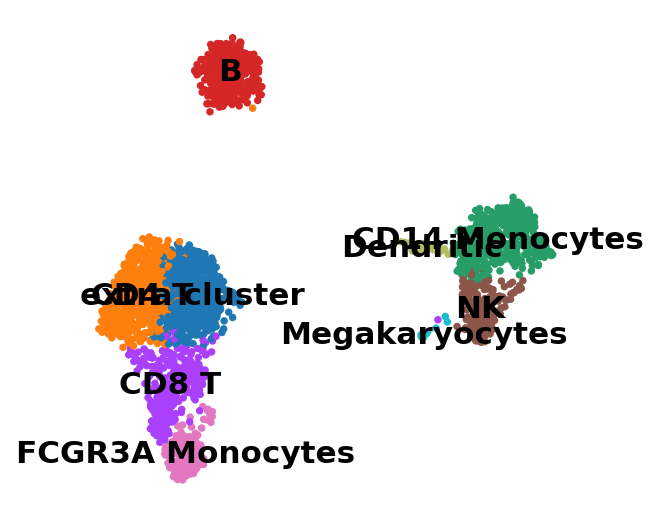

In [51]:
#label the cell types
new_cluster_names = [
    'extra cluster','CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T',
    'NK', 'FCGR3A Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('leiden', new_cluster_names)
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')


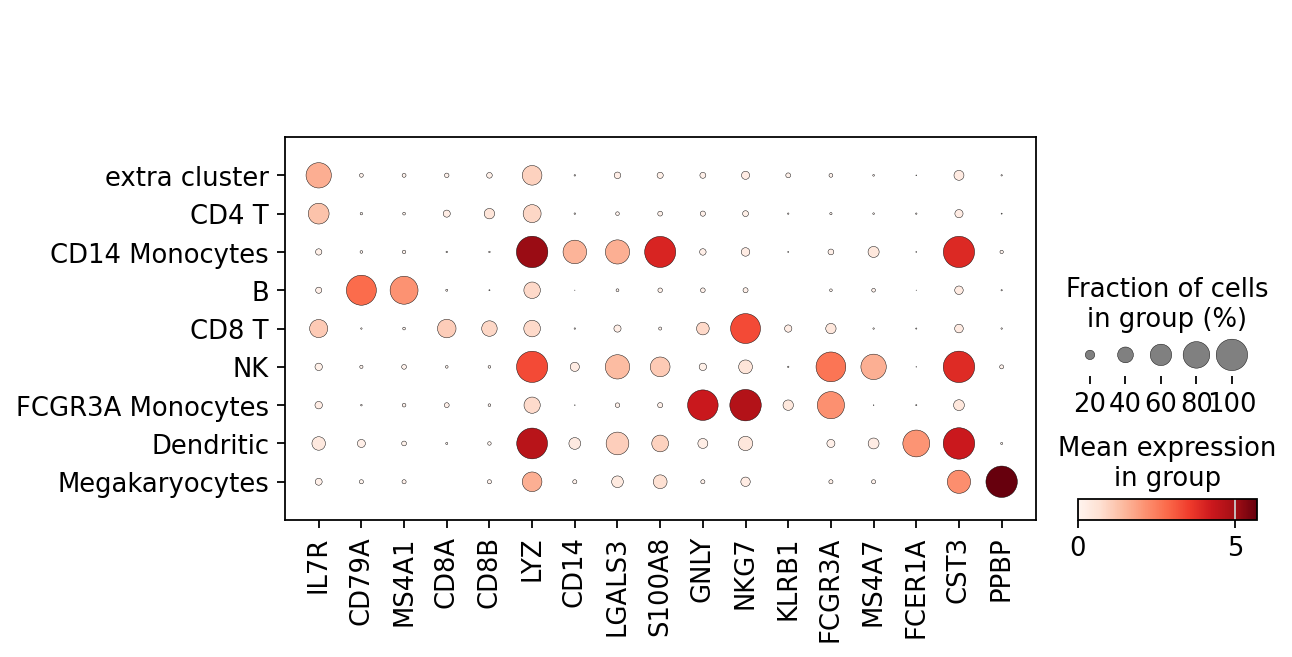

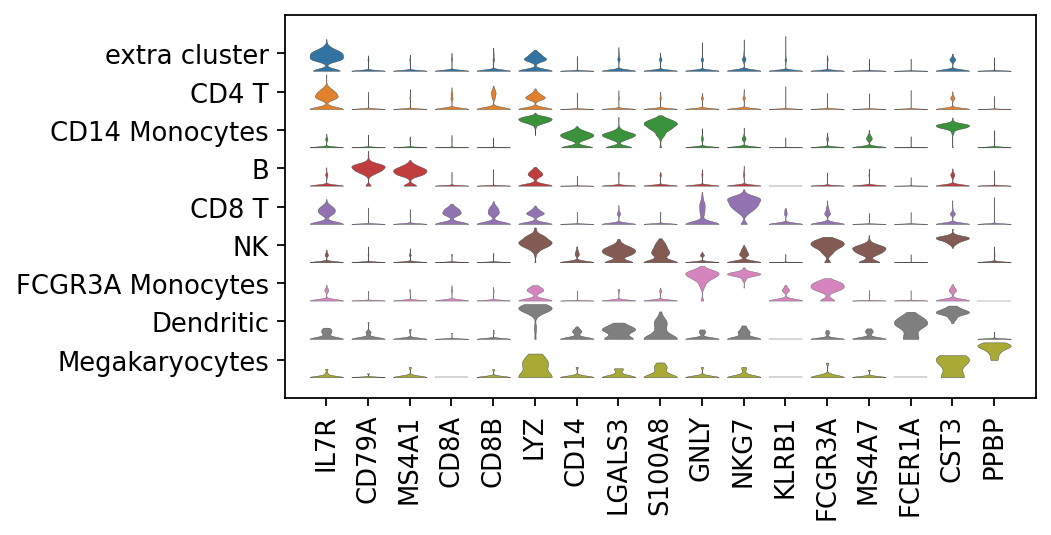

In [78]:
#visualize the marker genes in a dotplot
sc.pl.dotplot(adata, marker_genes, groupby='leiden');

#visualize marker gene distributions in a dot plot
colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728',
          '#9467bd','#8c564b','#e377c2','#7f7f7f',
          '#bcbd22','#17becf']
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', swap_axes=False, row_palette=colors);



In [80]:
#save results
adata.write(results_file, compression='gzip')  # `compression='gzip'` saves disk space, but slows down writing and subsequent reading

# if you want to export features to csv

# Export single fields of the annotation of observations
# adata.obs[['n_counts', 'louvain_groups']].to_csv(
#     './write/pbmc3k_corrected_louvain_groups.csv')

# Export single columns of the multidimensional annotation
# adata.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv(
#     './write/pbmc3k_corrected_X_pca.csv')

# Or export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
# adata.write_csvs(results_file[:-5], )
